# Synthesize a Table (Gaussian Coupla)

In this notebook, we'll use the SDV to create synthetic data for a single table and evaluate it. The SDV uses machine learning to learn patterns from real data and emulates them when creating synthetic data.

We'll use the **Gaussian Copula** algorithm to do this. Gaussian Copula is a fast, customizable and transparent way to synthesize data.

_Last Edit: Oct 2, 2024_

# 0. Installation

Install SDV Community.

In [1]:
%pip install sdv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# 1. Loading the demo data
For this demo, we'll use a fake dataset that describes some fictional guests staying at a hotel.

In [2]:
from sdv.datasets.demo import download_demo

real_data, metadata = download_demo(
    modality='single_table',
    dataset_name='fake_hotel_guests'
)

**Details**: The data is available as a single table.
- `guest_email` is a _primary key_ that uniquely identifies every row
- Other columns have a variety of data types and some the data may be missing.

In [3]:
print(f'{real_data.shape[0]} rows and {real_data.shape[1]} columns in the dataset')
real_data.head()

500 rows and 9 columns in the dataset


,guest_email,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,michaelsanders@shaw.net,False,BASIC,37.89,27 Dec 2020,29 Dec 2020,131.23,"49380 Rivers Street\nSpencerville, AK 68265",4075084747483975747
1,randy49@brown.biz,False,BASIC,24.37,30 Dec 2020,02 Jan 2021,114.43,"88394 Boyle Meadows\nConleyberg, TN 22063",180072822063468
2,webermelissa@neal.com,True,DELUXE,0.00,17 Sep 2020,18 Sep 2020,368.33,"0323 Lisa Station Apt. 208\nPort Thomas, LA 82585",38983476971380
3,gsims@terry.com,False,BASIC,NaN,28 Dec 2020,31 Dec 2020,115.61,"77 Massachusetts Ave\nCambridge, MA 02139",4969551998845740
4,misty33@smith.biz,False,BASIC,16.45,05 Apr 2020,NaN,122.41,"1234 Corporate Drive\nBoston, MA 02116",3558512986488983


The demo also includes **metadata**, a description of the dataset. It includes the primary keys as well as the data types for each column (called "sdtypes").

In [4]:
metadata.visualize()
print(metadata)

{
    "tables": {
        "fake_hotel_guests": {
            "primary_key": "guest_email",
            "columns": {
                "guest_email": {
                    "sdtype": "email",
                    "pii": true
                },
                "has_rewards": {
                    "sdtype": "boolean"
                },
                "room_type": {
                    "sdtype": "categorical"
                },
                "amenities_fee": {
                    "sdtype": "numerical",
                    "computer_representation": "Float"
                },
                "checkin_date": {
                    "sdtype": "datetime",
                    "datetime_format": "%d %b %Y"
                },
                "checkout_date": {
                    "sdtype": "datetime",
                    "datetime_format": "%d %b %Y"
                },
                "room_rate": {
                    "sdtype": "numerical",
                    "computer_representation": "Float"
   

# 2. Basic Usage

## 2.1 Creating a Synthesizer

An SDV **synthesizer** is an object that you can use to create synthetic data. It learns patterns from the real data and replicates them to generate synthetic data.

In [5]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(real_data)

Now the synthesizer is ready to use!

## 2.2 Generating Synthetic Data

Use the `sample` function and pass in any number of rows to synthesize.

In [6]:
synthetic_data = synthesizer.sample(num_rows=500)
synthetic_data.head()

,guest_email,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,dsullivan@example.net,False,BASIC,0.29,27 Mar 2020,09 Mar 2020,135.15,"90469 Karla Knolls Apt. 781\nSusanberg, CA 70033",5161033759518983
1,steven59@example.org,False,DELUXE,8.15,07 Sep 2020,25 Jun 2020,183.24,"6108 Carla Ports Apt. 116\nPort Evan, MI 71694",4133047413145475690
2,brandon15@example.net,False,BASIC,11.65,22 Mar 2020,01 Apr 2020,163.57,86709 Jeremy Manors Apt. 786\nPort Garychester...,4977328103788
3,humphreyjennifer@example.net,False,BASIC,48.12,04 Jun 2020,14 May 2020,127.75,"8906 Bobby Trail\nEast Sandra, NY 43986",3524946844839485
4,joshuabrown@example.net,False,DELUXE,11.07,08 Jan 2020,13 Jan 2020,180.12,"732 Dennis Lane\nPort Nicholasstad, DE 49786",4446905799576890978


The synthesizer is generating synthetic guests in the **same format as the original data**.

## 2.3 Evaluating Real vs. Synthetic Data

SDV has built-in functions for evaluating the synthetic data and getting more insight.

As a first step, we can run a **diagnostic** to ensure that the data is valid. SDV's diagnostic performs some basic checks such as:

- All primary keys must be unique
- Continuous values must adhere to the min/max of the real data
- Discrete columns (non-PII) must have the same categories as the real data
- Etc.

In [7]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 1123.67it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 249.54it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



<font color="green"><b>The score is 100%</b></font>, indicating that the data is fully valid.

We can also measure the **data quality** or the statistical similarity between the real and synthetic data. This value may vary anywhere from 0 to 100%.

In [8]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 813.29it/s]|
Column Shapes Score: 90.06%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 501.50it/s]|
Column Pair Trends Score: 89.29%

Overall Score (Average): 89.68%



According to the score, the synthetic data is about 88% similar to the real data in terms of statistical similarity.

We can also get more details from the report. For example, the Column Shapes sub-score is 89%. Which columns had the highest vs. the lowest scores?

In [9]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,has_rewards,TVComplement,0.982000
1,room_type,TVComplement,0.984000
2,amenities_fee,KSComplement,0.764778
3,checkin_date,KSComplement,0.962000
4,checkout_date,KSComplement,0.968750
5,room_rate,KSComplement,0.742000


## 2.4 Visualizing the Data
For more insights, we can visualize the real vs. synthetic data.

Let's perform a 1D visualization comparing a column of the real data to the synthetic data.

In [10]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name='room_rate',
    metadata=metadata
)

fig.show()

We can also visualize in 2D, comparing the correlations of a pair of columns.

In [11]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_names=['room_rate', 'room_type'],
    metadata=metadata
)

fig.show()

## 2.5 Anonymization

In the original dataset, we had some sensitive columns such as the guest's email, billing address and phone number. In the synthetic data, these columns are **fully anonymized** -- they contain entirely fake values that follow the format of the original.

PII columns are not included in the quality report, but we can inspect them to see that they are different.

In [12]:
sensitive_column_names = ['guest_email', 'billing_address', 'credit_card_number']

real_data[sensitive_column_names].head(3)

,guest_email,billing_address,credit_card_number
0,michaelsanders@shaw.net,"49380 Rivers Street\nSpencerville, AK 68265",4075084747483975747
1,randy49@brown.biz,"88394 Boyle Meadows\nConleyberg, TN 22063",180072822063468
2,webermelissa@neal.com,"0323 Lisa Station Apt. 208\nPort Thomas, LA 82585",38983476971380


In [13]:
synthetic_data[sensitive_column_names].head(3)

,guest_email,billing_address,credit_card_number
0,dsullivan@example.net,"90469 Karla Knolls Apt. 781\nSusanberg, CA 70033",5161033759518983
1,steven59@example.org,"6108 Carla Ports Apt. 116\nPort Evan, MI 71694",4133047413145475690
2,brandon15@example.net,86709 Jeremy Manors Apt. 786\nPort Garychester...,4977328103788


## 2.6 Saving and Loading
We can save the synthesizer to share with others and sample more synthetic data in the future.

In [14]:
synthesizer.save('my_synthesizer.pkl')

synthesizer = GaussianCopulaSynthesizer.load('my_synthesizer.pkl')

# 3. Gaussian Copula Customization

A key benefit of using the Gaussian Copula is **customization and transparency**. This synthesizer estimates the shape of every column using a 1D distribution. We can set these shapes ourselves.

In [15]:
custom_synthesizer = GaussianCopulaSynthesizer(
    metadata,
    default_distribution='truncnorm',
    numerical_distributions={
        'checkin_date': 'uniform',
        'checkout_date': 'uniform',
        'room_rate': 'gaussian_kde'
    }
)

custom_synthesizer.fit(real_data)

After training, we can inspect the distributions. In this case, the synthesizer returns the parameter it learned using the truncnorm distribution.

<font color=navy><i>More information about truncnorm distribution is available in the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html).</i></font>

In [16]:
learned_distributions = custom_synthesizer.get_learned_distributions()
learned_distributions['has_rewards']

{'distribution': 'truncnorm',
 'learned_parameters': {'a': np.float64(-0.5415003253031383),
  'b': np.float64(0.46460737566051247),
  'loc': np.float64(0.5390634681863229),
  'scale': np.float64(0.9878956157544778)}}

By setting these distributions strategically, you can make tradeoffs in the quality of your synthetic data.

In [17]:
synthetic_data_customized = custom_synthesizer.sample(num_rows=500)

quality_report = evaluate_quality(
    real_data,
    synthetic_data_customized,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 999.52it/s]|
Column Shapes Score: 93.49%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 584.63it/s]|
Column Pair Trends Score: 90.87%

Overall Score (Average): 92.18%



And we can verify this using the visualization functions.

In [23]:
fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data_customized,
    column_name='room_rate',
    metadata=metadata
)

fig.show()

# 4. Conditional Sampling
Another benefit of using the Gaussian Copula is the ability to **efficiently sample conditions**. This allows us to simulate hypothetical scenarios.

Let's start by creating a scenario where every hotel guest is staying in a `SUITE` (half with rewards and half without).

In [19]:
from sdv.sampling import Condition

suite_guests_with_rewards = Condition(
    num_rows=250,
    column_values={'room_type': 'SUITE', 'has_rewards': True}
)

suite_guests_without_rewards = Condition(
    num_rows=250,
    column_values={'room_type': 'SUITE', 'has_rewards': False}
)

Now we can simulate this scenario efficiently using our trained synthesizer.

In [20]:
simulated_synthetic_data = custom_synthesizer.sample_from_conditions(conditions=[
  suite_guests_with_rewards,
  suite_guests_without_rewards
])

Sampling conditions: 100%|██████████| 500/500 [00:00<00:00, 636.39it/s]


We can verify this by plotting the data.

In [21]:
fig = get_column_plot(
    real_data=real_data,
    synthetic_data=simulated_synthetic_data,
    column_name='room_type',
    metadata=metadata
)

fig.update_layout(
    title='Using synthetic data to simulate room_type scenario'
)

fig.show()

# 5. What's Next?

For more information about the Gaussian Copula Synthesizer, visit the **[documentation](https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/gaussiancopulasynthesizer)**.

**Need more help?** [Browse all tutorials](https://docs.sdv.dev/sdv/demos).


---

# About

The [Synthetic Data Vault Project](https://github.com/sdv-dev/SDV) was first created at MIT's Data to AI Lab in 2016. After 4 years of research and traction with enterprise, we created [DataCebo](https://datacebo.com/) in 2020 with the goal of growing the project. Today, DataCebo is the proud developer of SDV, the largest ecosystem for tabular synthetic data generation & evaluation.


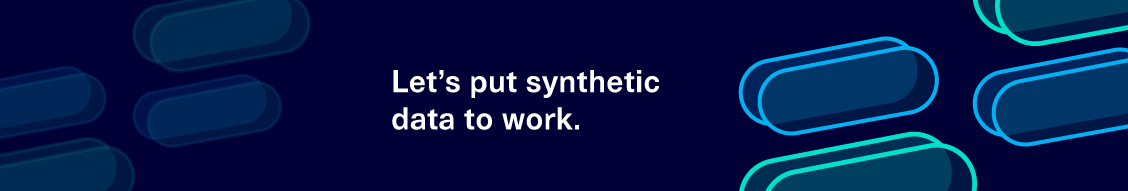